In [12]:
from carpool_data import posts, derived_posts

In [13]:
import pandas as pd
import matplotlib as mpl
import string
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [14]:
#first feature will be character count of the original post, transformed
posts["post_length"] = posts["message"].apply(lambda x: len(x))
posts["length_transformed"] = scipy.stats.boxcox(posts["post_length"])[0]

#2nd feature will be number of capitals, transformed
def num_of_caps(string):
    return sum(1 for c in string if c.isupper())

posts["number_of_caps"] = posts["message"].apply(lambda x: num_of_caps(x))
posts["caps_transformed"] = scipy.stats.boxcox(posts["number_of_caps"] + 1)[0]

In [15]:
#vectorizing the data (count vectorization)
def split_by_comma(x):
    return x.split(",")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split

count_vect = CountVectorizer(analyzer = split_by_comma)

#the training set of posts for number of routes
#in particular, the classified posts for number of routes
posts_tr_routes = posts[~posts["number_of_routes"].isnull()].reset_index(drop = True)

X_count = count_vect.fit_transform(posts_tr_routes["tockenized_message"])
X_count_feat = pd.DataFrame(X_count.toarray())

In [16]:
#add the features to the document turn matrix
#once again this is only for the classified ones
X_count_feat["length_transformed"] = posts_tr_routes["length_transformed"]
X_count_feat["caps_transformed"] = posts_tr_routes["caps_transformed"]
Y = posts_tr_routes["number_of_routes"]

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold,cross_val_score

rf = RandomForestClassifier()
param = {'n_estimators': [10,150,300], 'max_depth': [60,90,None]}

In [18]:
gs = GridSearchCV(rf, param, cv = 5, n_jobs = -1, return_train_score= True)
gs_fit = gs.fit(X_count_feat, Y)
pd.DataFrame(gs_fit.cv_results_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.027468,0.002795,0.932341,0.998311,60,10,"{'max_depth': 60, 'n_estimators': 10}",8,0.906667,1.000000,...,0.932432,0.996616,0.965753,0.994941,0.958621,1.000000,0.004988,7.599754e-04,0.026498,0.002135
1,0.368774,0.015249,0.939107,1.000000,60,150,"{'max_depth': 60, 'n_estimators': 150}",5,0.926667,1.000000,...,0.925676,1.000000,0.972603,1.000000,0.958621,1.000000,0.094724,3.125245e-03,0.022333,0.000000
2,0.920049,0.033490,0.944520,1.000000,60,300,"{'max_depth': 60, 'n_estimators': 300}",1,0.926667,1.000000,...,0.939189,1.000000,0.972603,1.000000,0.965517,1.000000,0.007730,1.022554e-03,0.020850,0.000000
3,0.042313,0.003207,0.939107,0.996961,90,10,"{'max_depth': 90, 'n_estimators': 10}",5,0.920000,0.996604,...,0.945946,0.998308,0.965753,0.994941,0.965517,0.994949,0.002719,4.006627e-04,0.025904,0.001965
4,0.467444,0.021858,0.939107,1.000000,90,150,"{'max_depth': 90, 'n_estimators': 150}",5,0.920000,1.000000,...,0.932432,1.000000,0.972603,1.000000,0.951724,1.000000,0.011578,8.155662e-03,0.020249,0.000000
5,0.891573,0.034491,0.943166,1.000000,90,300,"{'max_depth': 90, 'n_estimators': 300}",3,0.926667,1.000000,...,0.932432,1.000000,0.972603,1.000000,0.965517,1.000000,0.021217,2.877854e-03,0.021365,0.000000
6,0.038102,0.003008,0.929635,0.994930,None,10,"{'max_depth': None, 'n_estimators': 10}",9,0.906667,0.996604,...,0.918919,0.991540,0.952055,0.993255,0.951724,0.994949,0.001269,3.989506e-07,0.018546,0.002386
7,0.436962,0.016643,0.943166,1.000000,None,150,"{'max_depth': None, 'n_estimators': 150}",3,0.933333,1.000000,...,0.932432,1.000000,0.972603,1.000000,0.965517,1.000000,0.015198,1.022611e-03,0.022194,0.000000
8,0.766440,0.020662,0.944520,1.000000,None,300,"{'max_depth': None, 'n_estimators': 300}",1,0.933333,1.000000,...,0.932432,1.000000,0.972603,1.000000,0.965517,1.000000,0.038855,1.211400e-03,0.020470,0.000000


In [19]:
#since we dont have enough manual classifications,
#we will just differentiate between 1 and more than 1 route
Y2 = [0] * len(Y)
for i  in range(0,len(Y)):
    if(Y[i] > 1):
        Y2[i] = 2    
    else:
        Y2[i] = 1 

gs_fit = gs.fit(X_count_feat, Y2)
pd.DataFrame(gs_fit.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.026067,0.002399,0.945873,0.997294,60,10,"{'max_depth': 60, 'n_estimators': 10}",6,0.946309,0.994915,...,0.938776,0.996622,0.993197,0.996622,0.959184,0.998311,0.001692,4.974850e-04,0.032598,0.001727
1,0.390430,0.015031,0.953992,1.000000,60,150,"{'max_depth': 60, 'n_estimators': 150}",1,0.959732,1.000000,...,0.952381,1.000000,0.993197,1.000000,0.959184,1.000000,0.138458,3.760747e-03,0.027962,0.000000
2,1.064231,0.043516,0.953992,1.000000,60,300,"{'max_depth': 60, 'n_estimators': 300}",1,0.966443,1.000000,...,0.952381,1.000000,0.993197,1.000000,0.972789,1.000000,0.106097,1.237203e-02,0.036640,0.000000
3,0.040508,0.003208,0.941813,0.995601,90,10,"{'max_depth': 90, 'n_estimators': 10}",8,0.926174,0.993220,...,0.918367,0.996622,0.993197,0.994932,0.979592,0.996622,0.002423,4.015452e-04,0.038154,0.001358
4,0.500331,0.019051,0.947226,1.000000,90,150,"{'max_depth': 90, 'n_estimators': 150}",5,0.953020,1.000000,...,0.945578,1.000000,0.993197,1.000000,0.965986,1.000000,0.043191,1.677844e-03,0.037827,0.000000
5,0.898188,0.031484,0.951286,1.000000,90,300,"{'max_depth': 90, 'n_estimators': 300}",4,0.959732,1.000000,...,0.959184,1.000000,0.993197,1.000000,0.965986,1.000000,0.045319,1.022508e-03,0.038302,0.000000
6,0.050936,0.003008,0.932341,0.996279,None,10,"{'max_depth': None, 'n_estimators': 10}",9,0.926174,0.998305,...,0.945578,0.993243,0.993197,0.998311,0.925170,0.996622,0.008205,8.869684e-07,0.038882,0.001971
7,0.431748,0.017646,0.952639,1.000000,None,150,"{'max_depth': None, 'n_estimators': 150}",3,0.959732,1.000000,...,0.952381,1.000000,1.000000,1.000000,0.965986,1.000000,0.024227,1.022536e-03,0.037278,0.000000
8,0.764033,0.024665,0.945873,1.000000,None,300,"{'max_depth': None, 'n_estimators': 300}",6,0.953020,1.000000,...,0.931973,1.000000,0.993197,1.000000,0.972789,1.000000,0.037559,3.509006e-03,0.039176,0.000000


In [20]:
X_count2 = count_vect.fit(posts_tr_routes["tockenized_message"])
mes = "Test"
c = X_count2.transform([mes])
print(c)
#need to add the other 2 features into this

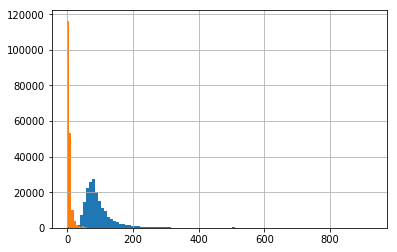

In [21]:
#a look at the distributions
posts["post_length"].hist(bins = 100)
posts["number_of_caps"].hist(bins = 50)
posts["length_transformed"].hist(bins=50)
posts["caps_transformed"].hist(bins=50)